In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import gc
import matplotlib.pyplot as plt

"""Change to the data folder"""
new_path = "./new_train/new_train/"

# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

### Create a dataset class 

In [4]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
val_dataset  = ArgoverseDataset(data_path=new_path)
test_dataset  = ArgoverseDataset(data_path="./new_val_in/new_val_in/")

In [5]:
len(val_dataset)
len(test_dataset)

3200

### Create a loader to enable batch processing

In [6]:
batch_sz = 1000

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    inp = torch.LongTensor(inp)
    out = torch.LongTensor(out)
    return [inp, out]

val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0)

In [6]:
#val_loader = DataLoader(val_dataset,batch_size=5000, shuffle = False, num_workers=0)

In [24]:
agent_p_in, agent_p_out = np.empty((1,2)), np.empty((1,2))
for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
    print(i_batch)
    if i_batch == 0:
        agent_p_in = inp.numpy()
        #agent_p_out = out.numpy() 
    else:
        temp1 = inp.numpy() 
        #temp2 = out.numpy() 
        agent_p_in = numpy.concatenate((agent_p_in,temp1))
        #agent_p_out = numpy.concatenate((agent_p_out,temp2))
    gc.collect()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


In [27]:
print(agent_p_in.shape)

(205942, 60, 19, 4)


In [34]:
agent_p_in = np.reshape(agent_p_in, (205942*60*19, 4))

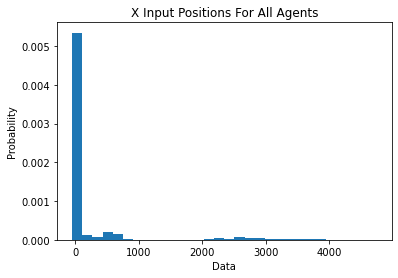

In [43]:
plt.hist(x=(agent_p_in[:,0]).T, density=True,  bins=30)
plt.title('X Input Positions For All Agents')
plt.ylabel('Probability')
plt.xlabel('Data');

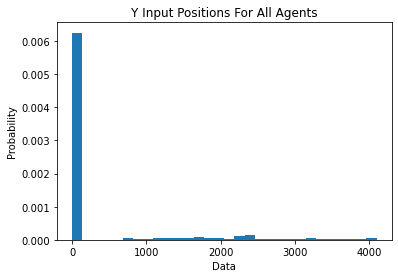

In [44]:
plt.hist(x=(agent_p_in[:,1]).T, density=True,  bins=30)
plt.title('Y Input Positions For All Agents')
plt.ylabel('Probability')
plt.xlabel('Data');

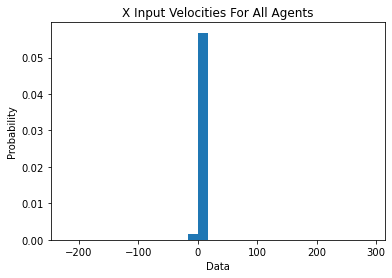

In [48]:
plt.hist(x=(agent_p_in[:,2]), density=True,  bins=30)
plt.title('X Input Velocities For All Agents')
plt.ylabel('Probability')
plt.xlabel('Data');

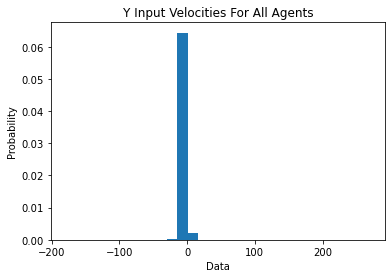

In [47]:
plt.hist(x=(agent_p_in[:,3]), density=True,  bins=30)
plt.title('Y Input Velocities For All Agents')
plt.ylabel('Probability')
plt.xlabel('Data');

In [ ]:
plt.hist(x=(agent_p_in[:,2]).T, density=True,  bins=30)
plt.title('X Input Velocities For Target Agent')
plt.ylabel('Probability')
plt.xlabel('Data');

In [ ]:
plt.hist(x=(agent_p_in[:,3]).T, density=True,  bins=30)
plt.title('Y Input Velocities For Target Agent')
plt.ylabel('Probability')
plt.xlabel('Data');

In [1]:
print(numpy.std(agent_p_in,axis=1))
print(numpy.mean(agent_p_in,axis=1))

NameError: name 'numpy' is not defined

In [ ]:
agent_p_out = numpy.empty((1,2))
for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
    if i_batch == 0:
        agent_p_out = out.numpy() 
    if i_batch%10 == 0:
        print(i_batch)
    else:
        temp2 = out.numpy()
        agent_p_out = numpy.concatenate((agent_p_out,temp2))
    gc.collect()

0
10
20
30
40
50
60
70
80
90


In [ ]:
print(agent_p_out.shape())
agent_p_in = np.reshape(agent_p_in, (205942*60*19, 4))

In [ ]:
plt.hist(x=(agent_p_out[:,0]), density=True,  bins=30)
plt.title('X Ouput Positions For All Agents')
plt.ylabel('Probability')
plt.xlabel('Data');

In [ ]:
plt.hist(x=(agent_p_out[:,1]), density=True,  bins=30)
plt.title('Y Ouput Positions For All Agents')
plt.ylabel('Probability')
plt.xlabel('Data');

In [ ]:
plt.hist(x=(agent_p_out[:,2]), density=True,  bins=30)
plt.title('X Ouput Velocities For All Agents')
plt.ylabel('Probability')
plt.xlabel('Data');

In [ ]:
plt.hist(x=(agent_p_out[:,3]).T, density=True,  bins=30)
plt.title('Y Ouput Velocities For All Agent')
plt.ylabel('Probability')
plt.xlabel('Data');

### Visualize the batch of sequences

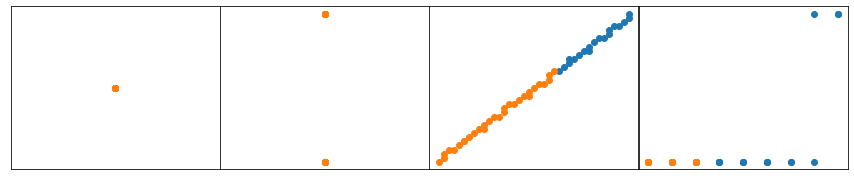

In [4]:
import matplotlib.pyplot as plt
import random

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

        
for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
    """TODO:
      Deep learning model
      training routine
    """
    show_sample_batch(sample_batch, agent_id)
    break